In [5]:
import pandas as pd

file_path = r"C:\Users\Sakshi Shah\Downloads\archive\powerdemand_5min_2021_to_2024_with weather.csv"
df = pd.read_csv(file_path)

# Drop unnecessary columns
df.drop(columns=['Unnamed: 0'], inplace=True)

# Convert 'datetime' column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'], format='%m/%d/%Y %H:%M')

# Handle missing values
df['wdir'].fillna(df['wdir'].median(), inplace=True)  # Fill missing wdir with median
df['moving_avg_3'].fillna(df['moving_avg_3'].mean(), inplace=True)  # Fill missing moving_avg_3 with mean

# Check and remove duplicates if any
df.drop_duplicates(inplace=True)

# Save cleaned data (optional)
cleaned_file_path = r"C:\Users\Sakshi Shah\Downloads\archive\cleaned_powerdemand.csv"
df.to_csv(cleaned_file_path, index=False)

# Display the first few rows of cleaned data
df.head()


,datetime,Power demand,temp,dwpt,rhum,wdir,wspd,pres,year,month,day,hour,minute,moving_avg_3
0,2021-01-01 00:30:00,2014.00,8.0,6.9,93,0.0,0.0,1017.0,2021,1,1,0,30,3960.746273
1,2021-01-01 00:35:00,2005.63,8.0,6.9,93,0.0,0.0,1017.0,2021,1,1,0,35,3960.746273
2,2021-01-01 00:40:00,1977.60,8.0,6.9,93,0.0,0.0,1017.0,2021,1,1,0,40,1999.076667
3,2021-01-01 00:45:00,1976.44,8.0,6.9,93,0.0,0.0,1017.0,2021,1,1,0,45,1986.556667
4,2021-01-01 00:50:00,1954.37,8.0,6.9,93,0.0,0.0,1017.0,2021,1,1,0,50,1969.470000


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Optional: Set Seaborn style for better visuals
sns.set_style("whitegrid")


Matplotlib is building the font cache; this may take a moment.


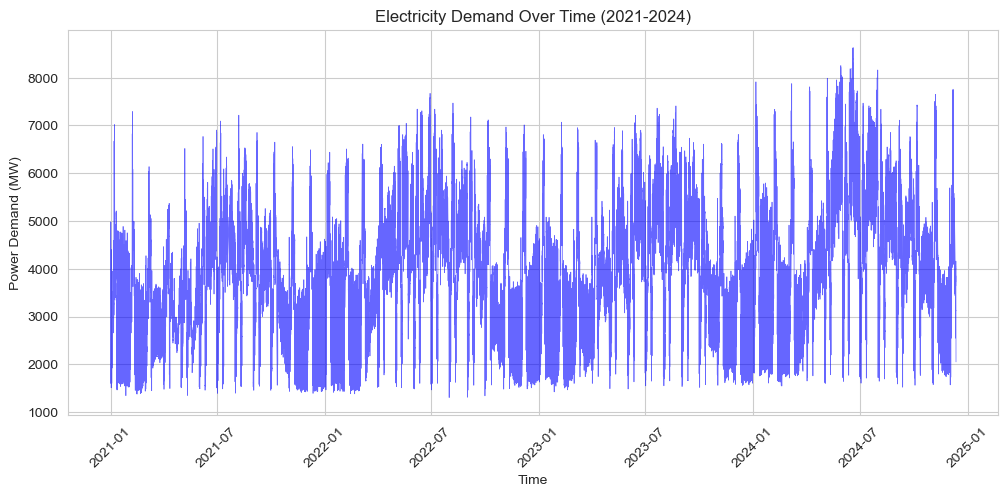

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(df['datetime'], df['Power demand'], color='blue', alpha=0.6, linewidth=0.5)
plt.xlabel("Time")
plt.ylabel("Power Demand (MW)")
plt.title("Electricity Demand Over Time (2021-2024)")
plt.xticks(rotation=45)
plt.show()


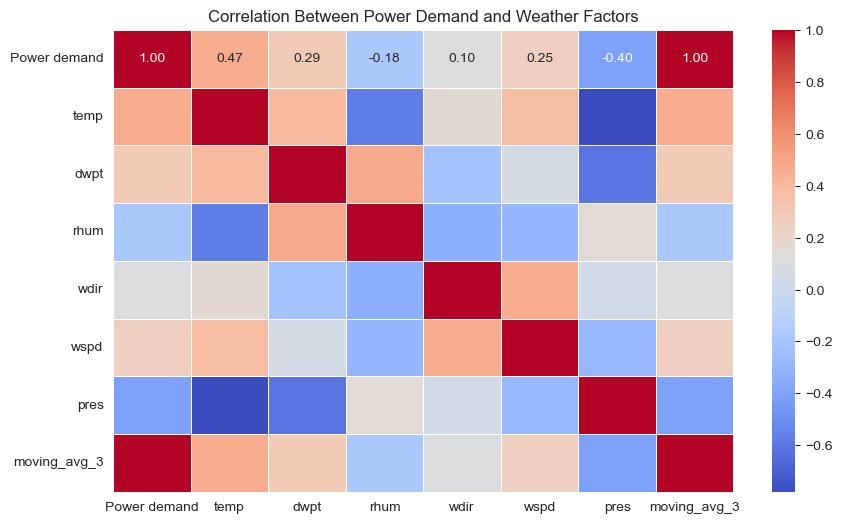

In [9]:
corr_matrix = df[['Power demand', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres', 'moving_avg_3']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Power Demand and Weather Factors")
plt.show()

In [15]:
import numpy as np  # Import NumPy
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Convert infinite values to NaN and handle missing values
df.replace([np.inf, -np.inf], np.nan, inplace=True)  
df.dropna(inplace=True)  # Drop rows with NaN values if necessary


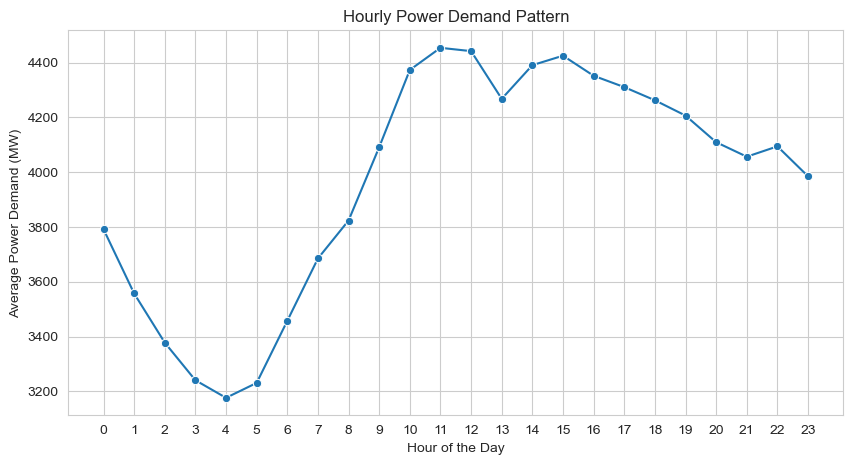

In [16]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=df.groupby("hour")["Power demand"].mean().index, 
             y=df.groupby("hour")["Power demand"].mean().values, marker="o")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Power Demand (MW)")
plt.title("Hourly Power Demand Pattern")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


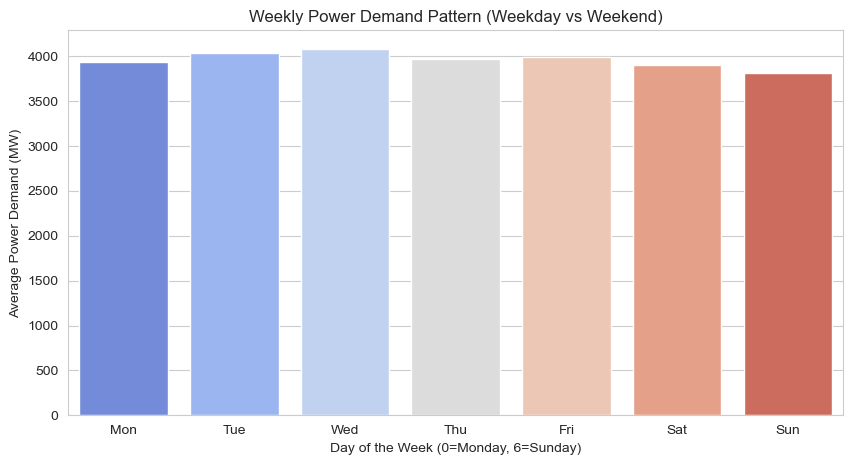

In [17]:
# Ensure datetime column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract day of the week (0=Monday, 6=Sunday)
df['day_of_week'] = df['datetime'].dt.dayofweek  

# Now, rerun the plot
plt.figure(figsize=(10, 5))
sns.barplot(x=df.groupby("day_of_week")["Power demand"].mean().index, 
            y=df.groupby("day_of_week")["Power demand"].mean().values, palette="coolwarm")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Average Power Demand (MW)")
plt.title("Weekly Power Demand Pattern (Weekday vs Weekend)")
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.show()


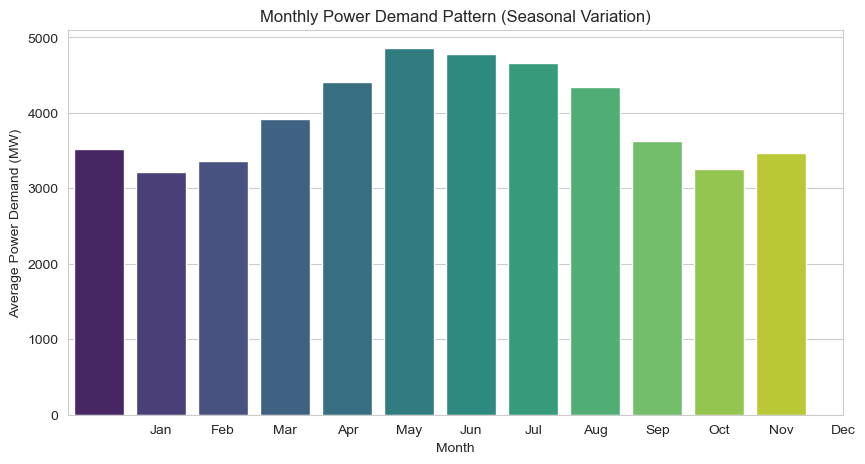

In [18]:
plt.figure(figsize=(10, 5))
sns.barplot(x=df.groupby("month")["Power demand"].mean().index, 
            y=df.groupby("month")["Power demand"].mean().values, palette="viridis")
plt.xlabel("Month")
plt.ylabel("Average Power Demand (MW)")
plt.title("Monthly Power Demand Pattern (Seasonal Variation)")
plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                                        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()


In [19]:
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract time-based features
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek  # Monday=0, Sunday=6
df['month'] = df['datetime'].dt.month
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # 1 for Saturday/Sunday


In [20]:
# Create lag features (e.g., last 1 hour, 3 hours, and 1 day)
df['lag_1'] = df['Power demand'].shift(1)  # 1 step before
df['lag_3'] = df['Power demand'].shift(3)  # 3 steps before
df['lag_24'] = df['Power demand'].shift(288)  # 1 day before (5-min intervals → 288 steps)


In [21]:
df['rolling_avg_3'] = df['Power demand'].rolling(window=3).mean()  # 3-step moving average
df['rolling_avg_24'] = df['Power demand'].rolling(window=288).mean()  # 1-day moving average


In [22]:
df['temp_x_demand'] = df['temp'] * df['Power demand']  # Interaction feature
df['humidity_x_demand'] = df['rhum'] * df['Power demand']


In [23]:
df.dropna(inplace=True)  # Remove rows with NaN values


In [24]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Select only numerical columns for scaling
features = ['Power demand', 'hour', 'day_of_week', 'month', 'is_weekend', 
            'lag_1', 'lag_3', 'lag_24', 'rolling_avg_3', 'rolling_avg_24', 
            'temp', 'rhum', 'temp_x_demand', 'humidity_x_demand']

# Initialize MinMaxScaler
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

# Convert back to DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=features)


In [25]:
from sklearn.model_selection import train_test_split

# Define input (X) and target (y)
X = df_scaled.drop(columns=['Power demand'])  # Features
y = df_scaled['Power demand']  # Target variable

# Convert to NumPy arrays
X, y = np.array(X), np.array(y)

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [26]:
# Reshape input to [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
